In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

### **Data Loading**

In [2]:
from tensorflow.keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print("train dataset shape:", train_images.shape, train_labels.shape)
print("test dataset shape:", test_images.shape, test_labels.shape)

170508288/170498071 [==============================] - 2s 0us/step
train dataset shape: (50000, 32, 32, 3) (50000, 1)
test dataset shape: (10000, 32, 32, 3) (10000, 1)


### **Preprocessing**
train_test_split은 이미 분리되어 있으므로 수행하지 않음

In [3]:
def preprocessed_data(images, labels):
    # 이미지 scale 및 float32 형 변형
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    return images, labels

def ohe_data(images, labels):
    # 라벨 원핫인코딩 적용
    images, labels = preprocessed_data(images, labels)
    oh_labels = to_categorical(labels)
    return images, oh_labels

In [4]:
train_images, train_labels = ohe_data(train_images, train_labels)
test_images, test_labels = ohe_data(test_images, test_labels)
print(train_images.shape, train_labels.shape)

(50000, 32, 32, 3) (50000, 10)


### **Modeling**

In [5]:
IMAGE_SIZE = 32

In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)) # 배치제외 3차원

x = Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten(name='Flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(train_labels.shape[1], activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0   

#### 가중치 초기화와 배치 정규화
* **WI** (glorot_uniform(default)) , **BN** (x) --> 0.7968
* **WI** (he_uniform), **BN** (O) --> 0.8271

In [15]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(x=train_images, y=train_labels, batch_size=64, epochs=30, validation_split=0.15)

Epoch 1/30
665/665 [==============================] - 6s 8ms/step - loss: 1.5692 - accuracy: 0.4320 - val_loss: 1.2805 - val_accuracy: 0.5364
Epoch 2/30
665/665 [==============================] - 5s 8ms/step - loss: 1.1303 - accuracy: 0.5925 - val_loss: 1.0133 - val_accuracy: 0.6311
Epoch 3/30
665/665 [==============================] - 5s 8ms/step - loss: 0.9367 - accuracy: 0.6663 - val_loss: 0.9295 - val_accuracy: 0.6616
Epoch 4/30
665/665 [==============================] - 5s 7ms/step - loss: 0.8151 - accuracy: 0.7131 - val_loss: 0.8731 - val_accuracy: 0.6940
Epoch 5/30
665/665 [==============================] - 5s 8ms/step - loss: 0.7335 - accuracy: 0.7462 - val_loss: 0.8024 - val_accuracy: 0.7276
Epoch 6/30
665/665 [==============================] - 5s 7ms/step - loss: 0.6639 - accuracy: 0.7698 - val_loss: 0.7241 - val_accuracy: 0.7460
Epoch 7/30
665/665 [==============================] - 5s 8ms/step - loss: 0.6059 - accuracy: 0.7902 - val_loss: 0.7569 - val_accuracy: 0.7497
Epoch 

313/313 [==============================] - 1s 3ms/step - loss: 0.6550 - accuracy: 0.8271


[0.6549835205078125, 0.8270999789237976]

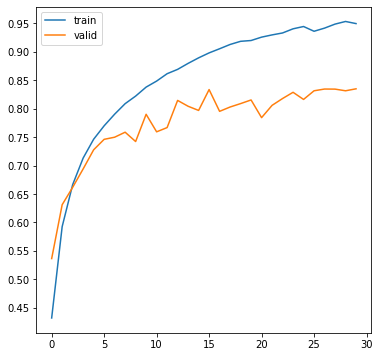

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

# 테스트 데이터로 성능 평가
model.evaluate(test_images, test_labels)